#  Генерация текста с использованием рекуррентных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Николенко С., Кадурин А., Архангельская Е. Глубокое обучение.
* https://pytorch.org/docs/stable/nn.html#recurrent-layers
* https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html


## Задачи для совместного разбора

1\. Рассмотрите основные шаги обучения модели для генерации текста с использованием RNN.

![text gen](https://www.tensorflow.org/static/text/tutorials/images/text_generation_sampling.png)

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
batch_size = 16
seq_len = 5

x = th.randint(0, 10, size=(batch_size, seq_len))
x.shape

torch.Size([16, 5])

In [ ]:
emb = nn.Embedding(num_embeddings=10, embedding_dim=32)
x_e = emb(x)
x_e.shape

torch.Size([16, 5, 32])

In [ ]:
rnn = nn.RNN(input_size=32, hidden_size=15, batch_first=True)
out, h = rnn(x_e)
out.shape, h.shape

(torch.Size([16, 5, 15]), torch.Size([1, 16, 15]))

In [ ]:
out[0].shape

torch.Size([5, 15])

In [ ]:
x[:, :-1][:4]

tensor([[3, 9, 7, 8],
        [6, 6, 4, 7],
        [5, 5, 1, 0],
        [5, 6, 5, 9]])

In [ ]:
x_train = x[:, :-1]
x_train_e = emb(x_train)
out, h = rnn(x_train_e)
out.shape

torch.Size([16, 4, 15])

In [ ]:
out_2d = out.reshape(16 * 4, 15)
out_2d.shape

torch.Size([64, 15])

In [ ]:
fc = nn.Linear(15, 10)
fc(out_2d).shape

torch.Size([64, 10])

## Задачи для самостоятельного решения

In [2]:
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import re

<p class="task" id="1"></p>

1\. Считайте файл `pets_ru_en.csv`, приведите имена питомцев к нижнем регистру. Создайте Vocab на основе загруженных данных (токен - __буква__). Добавьте в словарь специальные токены `<PAD>`, `<SOS>`, `<EOS>`. Выведите на экран количество токенов в полученном словаре.

- [x] Проверено на семинаре

In [3]:
df = pd.read_csv('pets_ru_en.csv')
df.columns = ['name', 'lang']
df.head(2)

,name,lang
0,Acapella,en
1,Achilles,en


In [4]:
df.drop_duplicates(subset='name', keep='first', inplace=True)

In [5]:
df['name'] = df['name'].str.lower()

In [6]:
vocab = build_vocab_from_iterator(df['name'], specials=['<PAD>', '<SOS>', '<EOS>'])
len(vocab)

63

<p class="task" id="2"></p>

2\. Создайте класс `PetsGenDataset`. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины (подходящее значение определите сами) и добавьте в начало каждого набора индекс `<SOS>`, а в конец - индекс токена `<EOS>`. Реализуйте `__getitem__` таким образом, чтобы он возвращал кортеж `(x, y)` в соответствии с приведенным рисунком. Создайте объект `DataLoader` с размером батча 128 и включенным `shuffle`. Выведите на экран размер `x` и `y` из одного батча.

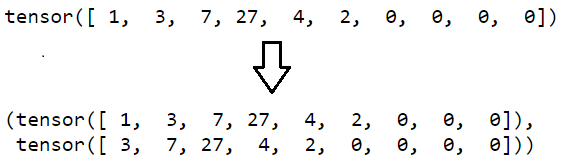

- [x] Проверено на семинаре

In [7]:
class PetsGenDataset:
  def __init__(self, data, vcb, transforms):
    self.names = data.values
    self.vcb = vcb
    self.transforms = transforms
    self.vcb_trans = T.VocabTransform(vcb)

  def __getitem__(self, idx):
    if isinstance(idx, slice):
      data = []
      for word in self.names[idx]:
        data.append(self.vcb.lookup_indices(list(word)))
      transformed = self.transforms(data)
      sos = th.tensor([self.vcb['<SOS>']]*transformed.shape[0])
      eos = th.tensor([self.vcb['<EOS>']]*transformed.shape[0])
      transformed = th.vstack([sos, transformed.transpose(0, 1), eos]).transpose(1, 0)
      return transformed[:, :-1], transformed[:, 1:]
    else:
      data = self.vcb.lookup_indices(list(self.names[idx]))
      sos = [self.vcb['<SOS>']]
      eos = [self.vcb['<EOS>']]
      data = sos + data + eos
      return self.transforms(data)[:-1], self.transforms(data)[1:]

  def __len__(self):
    return len(self.names)

In [8]:
transform = T.Sequential(
        T.ToTensor(0),
        T.PadTransform(max_length=30, pad_value=0)
    )
dataset = PetsGenDataset(df['name'], vcb=vocab, transforms=transform)

In [9]:
dataset[0]

(tensor([ 1,  6, 24,  6, 27,  5, 17, 17,  6,  2,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 tensor([ 6, 24,  6, 27,  5, 17, 17,  6,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]))

In [10]:
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [11]:
x, y = next(iter(loader))
x.shape, y.shape

(torch.Size([128, 29]), torch.Size([128, 29]))

<p class="task" id="3"></p>

3\. Напишите функцию, которая генерирует имя питомца при помощи обученной модели:
  * построение начинается с последовательности единичной длины, состоящей из индекса токена `<SOS>`;
  * начальное скрытое состояние RNN `h_t = None`;
  * в результате прогона последнего токена из построенной последовательности через модель получаете новое скрытое состояние `h_t` и распределение над всеми токенами из словаря;
  * выбираете 1 токен пропорционально вероятности и добавляете его в последовательность (можно воспользоваться `torch.multinomial`);
  * повторяете эти действия до тех пор, пока не сгенерирован токен `<EOS>` или не превышена максимальная длина последовательности;
  * функция возвращает строку из букв с первой заглавной буквой.
  
- [ ] Проверено на семинаре

In [13]:
def generate_pet_name(model, max_len, vcb):
  sequence = [vcb['<SOS>']]
  last_el = 1
  softmax = nn.Softmax(dim=1)
  while len(sequence) < max_len:
    res = model(th.tensor([last_el]))
    new_token_index = th.multinomial(softmax(res), 1).item()
    if new_token_index == vcb['<EOS>']:
      break
    sequence.append(new_token_index)
    last_el = new_token_index

  pet_name = ''.join(vcb.lookup_tokens(sequence[1:]))
  return pet_name.capitalize()

<p class="task" id="4"></p>

4\. Создайте и обучите модель для генерации имени питомца. Задача классификации ставится как предсказание следующего токена в каждом примере из пакета для каждого элемента последовательности (по прочитанной подстроке предсказывается следующий символ для данной строки). Каждые несколько эпох выводите примеры генерации имен при помощи текущего состояния модели. Игнорируйте токен `<PAD>` при расчете ошибки.

Примерная схема реализации метода `forward`:
```
input_X: [batch_size x seq_len] -> nn.Embedding -> emb_X: [batch_size x seq_len x embedding_size]
emb_X: [batch_size x seq_len x embedding_size] -> nn.RNN -> output: [batch_size x seq_len x hidden_size]
output: [batch_size x seq_len x hidden_size] -> torch.Tensor.reshape -> output: [batch_size * seq_len x hidden_size]
output: [batch_size * seq_len x hidden_size] -> nn.Linear -> output: [batch_size * seq_len x vocab_size]
```

- [ ] Проверено на семинаре

In [14]:
class RNN(nn.Module):
  def __init__(self, vcb, input_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(num_embeddings=len(vcb), embedding_dim=100, padding_idx=0)
    self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
    self.fc = nn.Linear(in_features=hidden_size, out_features=len(vcb))

  def forward(self, X):
    emb_X = self.emb(X)
    out, h = self.rnn(emb_X)
    out = out.reshape(-1, self.hidden_size)
    out = self.fc(out)
    return out

In [15]:
n_epoch = 100
lr = 0.001
model = RNN(vocab, input_size=100, hidden_size=50)
optimizer = optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss(ignore_index=0)

for epoch in range(1, n_epoch+1):
  for X_b, y_b in loader:
    out = model(X_b)
    loss = crit(out, th.flatten(y_b))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  if epoch % 10 == 0:
    name = generate_pet_name(model, max_len=10, vcb=vocab)
    print(f'{epoch=} loss={loss.item()} {name=}')

epoch=10 loss=2.581143856048584 name='Crкалолин'
epoch=20 loss=2.3373072147369385 name='Тjerasong'
epoch=30 loss=2.2509067058563232 name='Кейсильви'
epoch=40 loss=2.151841402053833 name='Grysddrin'
epoch=50 loss=2.2489471435546875 name='Дженя'
epoch=60 loss=2.1582634449005127 name='Мошана'
epoch=70 loss=2.143336296081543 name='Fiphozero'
epoch=80 loss=2.0951006412506104 name='Беy'
epoch=90 loss=2.068019151687622 name='Линя'
epoch=100 loss=2.063845634460449 name='Ithanigem'


<p class="task" id="5"></p>

5\. Считайте файл `pets_ru_en.csv`, приведите имена питомцев к нижнем регистру. Создайте Vocab на основе загруженных данных (токен - __буква__). Добавьте в словарь специальные токены `<PAD>`, `<SOS>`, `<EOS>`, `<RU>`, `<EN>`. Выведите на экран количество токенов в полученном словаре.

Модифицируйте датасет `PetsGenDataset` таким образом, чтобы в начало каждого примера добавлялся токен `<RU>`, если это имя питомца на русском, и `<EN>`, если имя на английском. Создайте объект `DataLoader` с размером батча 128 и включенным `shuffle`. Выведите на экран размер `x` и `y` из одного батча.

- [ ] Проверено на семинаре

In [16]:
vocab_ru_en = build_vocab_from_iterator(df['name'], specials=['<PAD>', '<SOS>', '<EOS>', '<RU>', '<EN>'])
len(vocab_ru_en)

65

In [35]:
class PetsGenDataset:
  def __init__(self, data, vcb, transforms):
    self.names = data['name'].values
    self.lang = data['lang'].values
    self.vcb = vcb
    self.transforms = transforms

  def __getitem__(self, idx):
    if isinstance(idx, slice):
      data = []
      for word, lang in zip(self.names[idx], self.lang[idx]):
        tokens = []
        if lang == 'rus':
          tokens.extend([self.vcb['<RU>'], self.vcb['<SOS>']])
        else:
          tokens.extend([self.vcb['<EN>'], self.vcb['<SOS>']])
        tokens.extend(self.vcb.lookup_indices(list(word)))
        data.append(tokens)
      transformed = self.transforms(data)
      eos = th.tensor([self.vcb['<EOS>']]*transformed.shape[0])
      transformed = th.vstack([transformed.transpose(0, 1), eos]).transpose(1, 0)
      return transformed[:, :-1], transformed[:, 1:]
    else:
      data = self.vcb.lookup_indices(list(self.names[idx]))
      lang = self.lang[idx]
      ru = [self.vcb['<RU>']]
      en = [self.vcb['<EN>']]
      eos = [self.vcb['<EOS>']]
      if lang == 'rus':
        data = ru + data + eos
      else:
        data = en + data + eos
      return self.transforms(data)[:-1], self.transforms(data)[1:]

  def __len__(self):
    return len(self.names)

In [36]:
transform = T.Sequential(
        T.ToTensor(0),
        T.PadTransform(max_length=35, pad_value=0)
    )
dataset = PetsGenDataset(df, vcb=vocab_ru_en, transforms=transform)

In [37]:
dataset[0]

(tensor([ 4,  8, 26,  8, 29,  7, 19, 19,  8,  2,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]),
 tensor([ 8, 26,  8, 29,  7, 19, 19,  8,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]))

In [38]:
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [39]:
x, y = next(iter(loader))
x.shape, y.shape

(torch.Size([128, 34]), torch.Size([128, 34]))

<p class="task" id="6"></p>

6\. Модифицируйте функцию для генерации имени, добавив возможность указать первый токен - `<RU>` или `<EN>`. Создайте и обучите модель для генерации имени питомца с указанием языка. Каждые несколько эпох выводите примеры генерации русскоязычных и англоязычных имен при помощи текущего состояния модели . Игнорируйте токен `<PAD>` при расчете ошибки.

- [ ] Проверено на семинаре


In [40]:
def generate_name_lang(model, max_len, vcb, lang='<RU>'):
  sequence = [vcb[lang], vcb['<SOS>']]
  last_el = sequence[-1]
  softmax = nn.Softmax(dim=1)
  while len(sequence) < max_len:
    res = model(th.tensor([last_el]))
    new_token_index = th.multinomial(softmax(res), 1).item()
    if new_token_index == vcb['<EOS>']:
      break
    sequence.append(new_token_index)
    last_el = new_token_index

  pet_name = ''.join(vcb.lookup_tokens(sequence[2:]))
  return pet_name.capitalize()

In [41]:
n_epoch = 100
lr = 0.001
model = RNN(vocab_ru_en, input_size=100, hidden_size=50)
optimizer = optim.Adam(model.parameters(), lr=lr)
crit = nn.CrossEntropyLoss(ignore_index=0)

for epoch in range(1, n_epoch+1):
  for X_b, y_b in loader:
    out = model(X_b)
    loss = crit(out, th.flatten(y_b))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  if epoch % 10 == 0:
    name = generate_name_lang(model, max_len=10, vcb=vocab_ru_en, lang='<RU>')
    print(f'{epoch=} loss={loss.item()} {name=}')

epoch=10 loss=2.4284400939941406 name='Сигээка'
epoch=20 loss=2.1904475688934326 name='Ия ыфира'
epoch=30 loss=2.1815407276153564 name='Иц<ru>мишан'
epoch=40 loss=2.2256813049316406 name='Ыраканьк'
epoch=50 loss=2.0171141624450684 name='Екацgore'
epoch=60 loss=2.1097614765167236 name='Олыжудfy'
epoch=70 loss=1.9943428039550781 name='Wсили'
epoch=80 loss=1.9986776113510132 name='Zzz'
epoch=90 loss=2.0350611209869385 name='Manesazг'
epoch=100 loss=2.0410284996032715 name='И'


## Обратная связь
- [x] Хочу получить обратную связь по решению